In [48]:
from datetime import datetime
import pandas as pd
import numpy as np
import yfinance as yf

df = yf.download('USDIDR=X', start="2016-01-01", end=datetime.today().strftime('%Y-%m-%d'))
df = df.reset_index()[['Date','Close']]
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Close
0,2015-12-31,13845.0
1,2016-01-01,13775.0
2,2016-01-04,13775.0
3,2016-01-05,13957.0
4,2016-01-06,13805.0


In [18]:
## Datetime conversion
df['Date'] = pd.to_datetime(df.Date)

# Setting the index
df.set_index('Date', inplace=True)
# Dropping any NaNs
df.dropna(inplace=True)

In [19]:
from sklearn.preprocessing import RobustScaler
close_scaler = RobustScaler()

close_scaler.fit(df[['Close']])

RobustScaler()

In [20]:
scaler = RobustScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

df.tail(10)

,Close
Date,
2020-11-18,0.163518
2020-11-19,0.251874
2020-11-20,0.336008
2020-11-23,0.294944
2020-11-24,0.309300
2020-11-25,0.264119
2020-11-26,0.270137
2020-11-27,0.027553
2020-11-30,0.200570


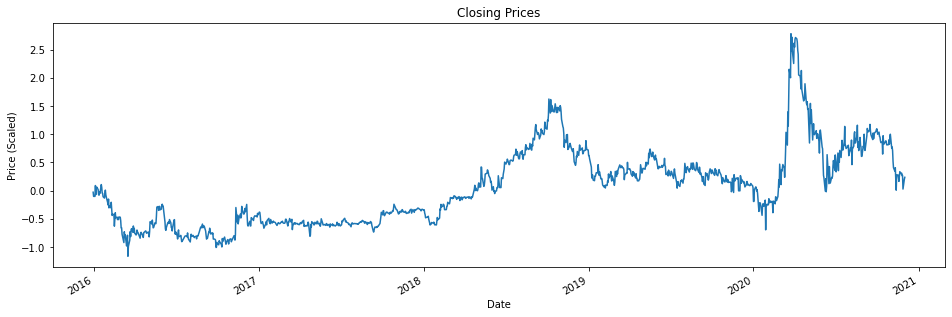

In [21]:
import matplotlib.pyplot as plt
# Plotting the Closing Prices
df['Close'].plot(figsize=(16,5))
plt.title("Closing Prices")
plt.ylabel("Price (Scaled)")
plt.show()

In [22]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    
    # Creating a list for both variables
    X, y = [], []
    
    for i in range(len(seq)):
        
        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break
        
        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [23]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [24]:
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

In [25]:
def validater(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])

    for i in range(n_per_in, len(df)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = df[-i - n_per_in:-i]

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))

        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions

In [26]:
# How many periods looking back to learn
n_per_in  = 60
# How many periods to predict
n_per_out = 30
# Features 
n_features = df.shape[1]
# Splitting the data into appropriate sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=1, 
            n_nodes=30, 
            activation=activ)

# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


checkpoint_path = "model_cp/"
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True,
                              save_weights_only=False)

early_stopping = EarlyStopping(
    monitor='val_loss', # akurasi yang dipantau
    patience=5, # jumlah epoch apabila tidak ada perubahan
    verbose=1, 
    mode='auto',
    baseline=None, 
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 90)            33120     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 30)            14520     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dense (Dense)                (None, 30)                1830      
Total params: 71,310
Trainable params: 71,310
Non-trainable params: 0
_________________________________________________________________


In [34]:
X.shape

(1192, 60, 1)

In [35]:
y.shape

(1192, 30)

In [ ]:
## Fitting and Training
res = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.1, callbacks=[cp_callback,
                                                                                 early_stopping])

In [ ]:
visualize_training_results(res)

In [ ]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)
    
# Plotting
plt.figure(figsize=(16,6))

# Plotting those predictions
plt.plot(predictions, label='Predicted')

# Plotting the actual values
plt.plot(actual, label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
from datetime import timedelta

# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]].tail(pers)), 
                      index=df.Close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.show()

#return preds

In [ ]:
df.tail(n_per_in)

In [ ]:
np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)

In [41]:
def predict(indexes, model_path):
    latest_period = 60
    from datetime import timedelta
    from sklearn.preprocessing import RobustScaler
    from tensorflow.keras.models import load_model
    import pandas as pd
    import numpy as np
    import yfinance as yf
    from datetime import datetime
    
    df_custom = yf.download(indexes, start="2016-01-01", end=datetime.today().strftime('%Y-%m-%d'))
    df_custom = df_custom.reset_index()[['Date','Close']]
    
    scaler = RobustScaler()
    scaled_close = scaler.fit_transform(df_custom[['Close']].values)
    df_custom['Close'] = scaled_close
    df_custom = df_custom.set_index('Date')

    model = load_model(model_path)

    # Predicting off of the most recent days from the original DF
    yhat = model.predict(np.array(df_custom['Close'].tail(latest_period)).reshape(1, latest_period, 1))

    # Transforming the predicted values back to their original format
    yhat = scaler.inverse_transform(yhat)[0]

    # Creating a DF of the predicted prices
    preds = pd.DataFrame(yhat, 
                         index=pd.date_range(start=df_custom.index[-1]+timedelta(days=1), 
                                             periods=len(yhat), 
                                             freq="B"), 
                         columns=[df_custom.columns[0]]).reset_index()
    preds = preds.rename(columns={'index':'Date'})
    save_path = "./predicted_data/"+indexes+".csv"
    preds.to_csv("./predicted_data/USDIDR=X.csv",index=None)
    return preds

In [42]:
#n_per_in = 180
new_df = predict('USDIDR=X', './model_cp')

[*********************100%***********************]  1 of 1 completed


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1281 entries, 0 to 1280
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1281 non-null   datetime64[ns]
 1   Close   1281 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.1 KB
